In [103]:
import matplotlib
matplotlib.use('Agg')      # a pure‐Python, non‐interactive backend
%matplotlib inline        


In [104]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image, display


In [105]:
import pandas as pd

# 1) Load your regression output
reg = pd.read_csv("regression_results.csv")

# 2) Quick sanity checks
print("Shape:", reg.shape)           # how many rows × columns?
print("Columns:", reg.columns.tolist())  
reg.head()                           # peek at the first 5 lines


Shape: (56848, 5)
Columns: ['Unnamed: 0', 'gene', 'peak_ID', 'coefficient', 'r2']


,Unnamed: 0,gene,peak_ID,coefficient,r2
0,0,Rp1,ImmGenATAC1219.peak_77,-0.012807,0.078561
1,1,Sox17,ImmGenATAC1219.peak_77,-0.003475,0.054538
2,2,Sox17,ImmGenATAC1219.peak_83,-0.001693,0.054538
3,3,Sox17,ImmGenATAC1219.peak_96,-0.003925,0.054538
4,4,Tcea1,ImmGenATAC1219.peak_137,0.922185,0.478855


In [106]:
annot = pd.read_csv("peaks_tss_distance.csv")
print("Annot shape:", annot.shape)
print("Annot cols:",  annot.columns.tolist())
annot.head()
# try a few relaxed cutoffs
for cutoff in [0.75, 0.7, 0.5, 0.2, 0.1, 0.05]:
    kept = (reg.r2 >= cutoff).sum()
    pct  = kept / len(reg) * 100
    print(f"R² ≥ {cutoff:<4} → {kept:5d} links ({pct:4.1f} %)")


Annot shape: (75857, 5)
Annot cols: ['ImmGenATAC1219.peakID', 'chrom', 'peak_center', 'closest_tss', 'distance_to_tss']
R² ≥ 0.75 → 24816 links (43.7 %)
R² ≥ 0.7  → 28746 links (50.6 %)
R² ≥ 0.5  → 41710 links (73.4 %)
R² ≥ 0.2  → 52155 links (91.7 %)
R² ≥ 0.1  → 54249 links (95.4 %)
R² ≥ 0.05 → 55315 links (97.3 %)


In [107]:
import pandas as pd

# your regression results
reg = pd.read_csv("regression_results.csv")

# your TSS–distance lookup
dist = pd.read_csv("peaks_tss_distance.csv")

dist = dist.rename(columns={"ImmGenATAC1219.peakID": "peak_ID"})


In [108]:
reg2 = reg.merge(
    dist[["peak_ID","distance_to_tss"]],
    on="peak_ID",
    how="left",
    validate="m:1"   # many reg rows → one dist row
)


In [109]:
n_missing = reg2["distance_to_tss"].isna().sum()
print(f"{n_missing} links have no distance; all others got filled in.")


0 links have no distance; all others got filled in.


In [110]:
print(reg2.shape)        # should be same # rows as reg
reg2.head()


(56848, 6)


,Unnamed: 0,gene,peak_ID,coefficient,r2,distance_to_tss
0,0,Rp1,ImmGenATAC1219.peak_77,-0.012807,0.078561,6702.0
1,1,Sox17,ImmGenATAC1219.peak_77,-0.003475,0.054538,6702.0
2,2,Sox17,ImmGenATAC1219.peak_83,-0.001693,0.054538,875.0
3,3,Sox17,ImmGenATAC1219.peak_96,-0.003925,0.054538,74643.0
4,4,Tcea1,ImmGenATAC1219.peak_137,0.922185,0.478855,10510.0


In [111]:
# 1) apply your R² cutoff
high_conf = reg2[reg2["r2"] >= 0.7].copy()

# 2) how many remain?
print(f"{len(high_conf)} links out of {len(reg2)} pass R² ≥ 0.7")

# 3) peek at them
high_conf.head(10)


28746 links out of 56848 pass R² ≥ 0.7


,Unnamed: 0,gene,peak_ID,coefficient,r2,distance_to_tss
13,13,Pcmtd1,ImmGenATAC1219.peak_376,-1.367742,0.752231,394.0
14,14,Pcmtd1,ImmGenATAC1219.peak_377,-2.494725,0.752231,144.0
15,15,Pcmtd1,ImmGenATAC1219.peak_378,3.276884,0.752231,132.0
16,16,Pcmtd1,ImmGenATAC1219.peak_380,5.020475,0.752231,7143.0
17,17,Pcmtd1,ImmGenATAC1219.peak_408,0.983100,0.752231,58306.0
18,18,Pcmtd1,ImmGenATAC1219.peak_413,7.729939,0.752231,75027.0
22,22,Sgk3,ImmGenATAC1219.peak_577,-0.586173,0.820577,93.0
23,23,Sgk3,ImmGenATAC1219.peak_594,3.325265,0.820577,81.0
24,24,Sgk3,ImmGenATAC1219.peak_601,13.819465,0.820577,8000.0
25,25,Sgk3,ImmGenATAC1219.peak_602,7.729455,0.820577,9691.0


In [112]:
# 1) start from your high‐confidence links (R² ≥ 0.7)
#    assume you already have:
#       high_conf = reg2[reg2["r2"] >= 0.7].copy()

# 2) find, for each gene, the promoter peak
#    (i.e. among positive‐coef peaks, the one with smallest distance_to_tss)
pos = high_conf[high_conf["coefficient"] > 0]
promoter_idx = pos.groupby("gene")["distance_to_tss"].idxmin()
promoters = pos.loc[promoter_idx, ["gene", "peak_ID"]]
promoter_map = promoters.set_index("gene")["peak_ID"].to_dict()

# 3) assign role to every link
def assign_role(row):
    gene = row["gene"]
    peak = row["peak_ID"]
    coef = row["coefficient"]
    if peak == promoter_map.get(gene):
        return "promoter"
    elif coef > 0:
        return "activator"
    else:
        return "repressor"

high_conf["role"] = high_conf.apply(assign_role, axis=1)

# 4) preview
high_conf[["gene","peak_ID","coefficient","r2","distance_to_tss","role"]].head(20)


,gene,peak_ID,coefficient,r2,distance_to_tss,role
13,Pcmtd1,ImmGenATAC1219.peak_376,-1.367742,0.752231,394.0,repressor
14,Pcmtd1,ImmGenATAC1219.peak_377,-2.494725,0.752231,144.0,repressor
15,Pcmtd1,ImmGenATAC1219.peak_378,3.276884,0.752231,132.0,promoter
16,Pcmtd1,ImmGenATAC1219.peak_380,5.020475,0.752231,7143.0,activator
17,Pcmtd1,ImmGenATAC1219.peak_408,0.983100,0.752231,58306.0,activator
18,Pcmtd1,ImmGenATAC1219.peak_413,7.729939,0.752231,75027.0,activator
22,Sgk3,ImmGenATAC1219.peak_577,-0.586173,0.820577,93.0,repressor
23,Sgk3,ImmGenATAC1219.peak_594,3.325265,0.820577,81.0,activator
24,Sgk3,ImmGenATAC1219.peak_601,13.819465,0.820577,8000.0,activator
25,Sgk3,ImmGenATAC1219.peak_602,7.729455,0.820577,9691.0,activator


In [113]:
# filter for Ltb
ltb = high_conf[high_conf["gene"] == "Ltb"]

# select the columns we care about
ltb[["peak_ID","distance_to_tss","coefficient","r2","role"]]


,peak_ID,distance_to_tss,coefficient,r2,role
22173,ImmGenATAC1219.peak_213552,242.0,-3.520328,0.893846,repressor
22174,ImmGenATAC1219.peak_213561,2561.0,-39.880566,0.893846,repressor
22175,ImmGenATAC1219.peak_213568,4222.0,8.742759,0.893846,activator
22176,ImmGenATAC1219.peak_213574,1623.0,75.062982,0.893846,activator
22177,ImmGenATAC1219.peak_213584,135.0,69.126157,0.893846,activator
22178,ImmGenATAC1219.peak_213585,131.0,10.576468,0.893846,activator
22179,ImmGenATAC1219.peak_213588,855.0,-28.484788,0.893846,repressor
22180,ImmGenATAC1219.peak_213591,1343.0,-1.519843,0.893846,repressor
22181,ImmGenATAC1219.peak_213603,5029.0,13.044219,0.893846,activator
22182,ImmGenATAC1219.peak_213620,3762.0,8.489428,0.893846,activator


In [114]:
# 1) Assuming you already have ‘high_conf’ from:
#    high_conf = reg2[reg2["r2"] >= 0.7].copy()

# 2) Just tally up the roles:
role_counts = high_conf["role"].value_counts().rename_axis("role").reset_index(name="count")
print(role_counts)


        role  count
0  repressor  13025
1  activator  12707
2   promoter   3014


In [115]:
# 1) Filter for promoters
promoters = high_conf[high_conf["role"] == "promoter"].copy()

# 2) Peek at the first 20 promoter links
print(promoters[["gene","peak_ID","distance_to_tss"]].head(20))

# 3) Get summary statistics on their distances
print(promoters["distance_to_tss"].describe())


         gene                   peak_ID  distance_to_tss
15     Pcmtd1   ImmGenATAC1219.peak_378            132.0
28       Sgk3   ImmGenATAC1219.peak_623             16.0
47    Arfgef1   ImmGenATAC1219.peak_720           7046.0
80       Eya1  ImmGenATAC1219.peak_1471             92.0
88     Sbspon  ImmGenATAC1219.peak_1657             59.0
102     Stau2  ImmGenATAC1219.peak_1805            341.0
115   Gm16070  ImmGenATAC1219.peak_1988             63.0
116  Crispld1  ImmGenATAC1219.peak_1985           8414.0
126      Mcm3  ImmGenATAC1219.peak_2124             36.0
134     Paqr8  ImmGenATAC1219.peak_2124             36.0
161     Kcnq5  ImmGenATAC1219.peak_2447            632.0
167    Ogfrl1  ImmGenATAC1219.peak_2558            220.0
176     Smap1  ImmGenATAC1219.peak_2659            278.0
227    Ptpn18  ImmGenATAC1219.peak_3481             48.0
250      Cfc1  ImmGenATAC1219.peak_3481             48.0
265   Plekhb2  ImmGenATAC1219.peak_3632             13.0
289    Arid5a  ImmGenATAC1219.p

In [116]:
# Sort by distance, descending
print(promoters[["gene","peak_ID","distance_to_tss"]]
      .sort_values("distance_to_tss", ascending=False)
      .head(10))


                gene                     peak_ID  distance_to_tss
26193         Mamdc2  ImmGenATAC1219.peak_248648          79408.0
51068         Rnf150  ImmGenATAC1219.peak_463338          76793.0
31295        Fam217b  ImmGenATAC1219.peak_297365          75720.0
12413         Dio3os  ImmGenATAC1219.peak_115854          71897.0
16769            Ghr  ImmGenATAC1219.peak_164962          71438.0
8268           Wscd1   ImmGenATAC1219.peak_80643          69999.0
50237          Hmgb2  ImmGenATAC1219.peak_458765          68203.0
16696          Farp1  ImmGenATAC1219.peak_163849          67147.0
5992   9230105E05Rik   ImmGenATAC1219.peak_63516          65501.0
26307           Gldc  ImmGenATAC1219.peak_250056          61987.0


In [117]:
# assume `high_conf` is your R² ≥ 0.7 table with 'role' and 'distance_to_tss'

# 1) Boolean mask for far-away promoters
far_promoters = (high_conf["role"] == "promoter") & (high_conf["distance_to_tss"] > 1000)

# 2) Remove them from the high_conf table
high_conf_filtered = high_conf[~far_promoters].copy()

# 3) Quick sanity check:
print(f"Removed {far_promoters.sum()} promoters >1 kb away")
print("Remaining promoters:")
print(high_conf_filtered[high_conf_filtered["role"]=="promoter"]["distance_to_tss"].describe())

# high_conf_filtered now has no promoters farther than 1 kb


Removed 524 promoters >1 kb away
Remaining promoters:
count    2490.000000
mean      102.701205
std       155.703767
min         0.000000
25%        18.000000
50%        44.000000
75%       106.000000
max       990.000000
Name: distance_to_tss, dtype: float64


In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) save to disk
high_conf_filtered.to_csv("high_conf_filtered.csv", index=False)
print("Wrote high_conf_filtered.csv —", high_conf_filtered.shape[0], "rows")

import matplotlib.pyplot as plt
import seaborn as sns

# 1) Set a minimalist style
sns.set_style("whitegrid", {
    "grid.color":      "#cccccc",
    "grid.linestyle":  "--",
    "axes.edgecolor":  "#333333",
    "axes.linewidth":  1.0,
})
plt.rc("font", family="sans-serif", size=12)

# 2) Prepare the data: split activators vs repressors/promoters
pos = high_conf_filtered[high_conf_filtered["coefficient"] >= 0]
neg = high_conf_filtered[high_conf_filtered["coefficient"] <  0]

# 3) Create two subplots, sharing the x-axis
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1,
    figsize=(10, 8),
    sharex=True,
    gridspec_kw={"height_ratios": [1, 1]}
)

# 4) Plot positive coefficients (activators + promoters)
sns.scatterplot(
    data=pos,
    x="distance_to_tss", y="coefficient",
    hue="role",
    palette={"activator":"#2ca02c", "promoter":"#1f77b4"},
    edgecolor="w", linewidth=0.3,
    alpha=0.7,
    s=40,
    ax=ax1
)
ax1.axhline(0, color="black", linewidth=0.8)
ax1.set_title("Positive Effects (Activators & Promoters)")
ax1.set_ylabel("Coefficient ≥ 0")
ax1.legend(title="CRE Role", loc="upper left")

# 5) Plot negative coefficients (repressors only)
sns.scatterplot(
    data=neg,
    x="distance_to_tss", y="coefficient",
    hue="role",
    palette={"repressor":"#d62728"},
    edgecolor="w", linewidth=0.3,
    alpha=0.7,
    s=40,
    ax=ax2,
    legend=False
)
ax2.axhline(0, color="black", linewidth=0.8)
ax2.set_title("Negative Effects (Repressors)")
ax2.set_ylabel("Coefficient < 0")
ax2.set_xlabel("Distance to TSS (bp, log scale)")

# 6) Final tweaks
for ax in (ax1, ax2):
    ax.set_xscale("log")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


Wrote high_conf_filtered.csv — 28222 rows


RuntimeError: latex was not able to process the following string:
b'Coefficient \\u2265 0'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp93bpxxnl 0f503ee711de8949be177510fa2e93e19c4b843d53cbc906f93e5138ddb4dc3f.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.26 (TeX Live 2024) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./0f503ee711de8949be177510fa2e93e19c4b843d53cbc906f93e5138ddb4dc3f.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-02-20>
(/usr/local/texlive/2024/texmf-dist/tex/latex/base/article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(/usr/local/texlive/2024/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2024/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2024/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2024/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2024/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2024/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2024/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2024/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2024/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2024/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/local/texlive/2024/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/local/texlive/2024/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/local/texlive/2024/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/local/texlive/2024/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/local/texlive/2024/texmf-dist/tex/latex/amsfonts/amssymb.sty
(/usr/local/texlive/2024/texmf-dist/tex/latex/amsfonts/amsfonts.sty))
(/usr/local/texlive/2024/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/local/texlive/2024/texmf-dist/tex/latex/firstaid/underscore-ltx.sty)
(/usr/local/texlive/2024/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2024/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 0f503ee711de8949be177510fa2e93e19c4b843d53cbc906f93e5138ddb4dc3f.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! LaTeX Error: Unicode character ≥ (U+2265)
               not set up for use with LaTeX.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.30 {\sffamily Coefficient ≥
                                0}%
No pages of output.
Transcript written on tmp93bpxxnl/0f503ee711de8949be177510fa2e93e19c4b843d53cbc
906f93e5138ddb4dc3f.log.




Error in callback <function _draw_all_if_interactive at 0x132b22cb0> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: latex was not able to process the following string:
b'Coefficient \\u2265 0'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpn1732qj5 0f503ee711de8949be177510fa2e93e19c4b843d53cbc906f93e5138ddb4dc3f.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.26 (TeX Live 2024) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./0f503ee711de8949be177510fa2e93e19c4b843d53cbc906f93e5138ddb4dc3f.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-02-20>
(/usr/local/texlive/2024/texmf-dist/tex/latex/base/article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(/usr/local/texlive/2024/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2024/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2024/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2024/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2024/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2024/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2024/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2024/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2024/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2024/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/local/texlive/2024/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/local/texlive/2024/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/local/texlive/2024/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/local/texlive/2024/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/local/texlive/2024/texmf-dist/tex/latex/amsfonts/amssymb.sty
(/usr/local/texlive/2024/texmf-dist/tex/latex/amsfonts/amsfonts.sty))
(/usr/local/texlive/2024/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/local/texlive/2024/texmf-dist/tex/latex/firstaid/underscore-ltx.sty)
(/usr/local/texlive/2024/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2024/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 0f503ee711de8949be177510fa2e93e19c4b843d53cbc906f93e5138ddb4dc3f.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! LaTeX Error: Unicode character ≥ (U+2265)
               not set up for use with LaTeX.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.30 {\sffamily Coefficient ≥
                                0}%
No pages of output.
Transcript written on tmpn1732qj5/0f503ee711de8949be177510fa2e93e19c4b843d53cbc
906f93e5138ddb4dc3f.log.




RuntimeError: latex was not able to process the following string:
b'Coefficient \\u2265 0'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp1v6spok0 0f503ee711de8949be177510fa2e93e19c4b843d53cbc906f93e5138ddb4dc3f.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.26 (TeX Live 2024) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./0f503ee711de8949be177510fa2e93e19c4b843d53cbc906f93e5138ddb4dc3f.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-02-20>
(/usr/local/texlive/2024/texmf-dist/tex/latex/base/article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(/usr/local/texlive/2024/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2024/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2024/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2024/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2024/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2024/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2024/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2024/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2024/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2024/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/local/texlive/2024/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/local/texlive/2024/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/local/texlive/2024/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/local/texlive/2024/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/local/texlive/2024/texmf-dist/tex/latex/amsfonts/amssymb.sty
(/usr/local/texlive/2024/texmf-dist/tex/latex/amsfonts/amsfonts.sty))
(/usr/local/texlive/2024/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/local/texlive/2024/texmf-dist/tex/latex/firstaid/underscore-ltx.sty)
(/usr/local/texlive/2024/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2024/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 0f503ee711de8949be177510fa2e93e19c4b843d53cbc906f93e5138ddb4dc3f.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! LaTeX Error: Unicode character ≥ (U+2265)
               not set up for use with LaTeX.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.30 {\sffamily Coefficient ≥
                                0}%
No pages of output.
Transcript written on tmp1v6spok0/0f503ee711de8949be177510fa2e93e19c4b843d53cbc
906f93e5138ddb4dc3f.log.




<Figure size 1000x800 with 2 Axes>

In [119]:
# write to your Desktop
high_conf_filtered.to_csv("~/Desktop/high_conf_filtered.csv", index=False)
print("Wrote ~/Desktop/high_conf_filtered.csv —", high_conf_filtered.shape[0], "rows")


Wrote ~/Desktop/high_conf_filtered.csv — 28222 rows


In [120]:
import pandas as pd

# 1) Most repressive “repressor”
most_repressive = (
    high_conf[high_conf.role == "repressor"]
     .nsmallest(1, "coefficient")
     .loc[:, ["peak_ID","gene","distance_to_tss","coefficient"]]
)
print("Most repressive repressor:\n", most_repressive)

# 2) Genes with all three roles
roles_per_gene = high_conf.groupby("gene")["role"] \
                          .unique().apply(set)
n_all3 = sum(1 for roles in roles_per_gene
             if {"promoter","activator","repressor"}.issubset(roles))
print(f"Genes with all 3 roles: {n_all3}")

# 3) Genes with only a promoter
n_only_prom = sum(1 for roles in roles_per_gene
                  if roles == {"promoter"})
print(f"Genes with only promoter: {n_only_prom}")

# 4) Average counts of promoters & enhancers per gene
counts = high_conf.groupby("gene")["role"] \
                  .value_counts() \
                  .unstack(fill_value=0)
avg_prom  = counts["promoter"].mean()
avg_enh   = counts[["activator","repressor"]].sum(axis=1).mean()
print(f"Avg # promoters per gene: {avg_prom:.2f}")
print(f"Avg # enhancers per gene: {avg_enh:.2f}")


Most repressive repressor:
                         peak_ID  gene  distance_to_tss  coefficient
7311  ImmGenATAC1219.peak_75525  Tcf7          14254.0  -253.532701
Genes with all 3 roles: 2692
Genes with only promoter: 66
Avg # promoters per gene: 1.00
Avg # enhancers per gene: 8.51


Where are repressing CREs located compared to activating CREs?


In [121]:
conda install -c conda-forge tabulate


Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [122]:
summary = (
    high_conf
    .groupby('role')['distance_to_tss']
    .describe()[['count','min','25%','50%','75%','max']]
    .sort_index()
)
print(summary.to_markdown())


| role      |   count |   min |   25% |   50% |     75% |   max |
|:----------|--------:|------:|------:|------:|--------:|------:|
| activator |   12707 |     1 |   473 |  4942 | 16780.5 | 99778 |
| promoter  |    3014 |     0 |    23 |    61 |   296   | 79408 |
| repressor |   13025 |     0 |   126 |  1303 | 11544   | 99880 |


In [123]:
summary = (
    high_conf
    .groupby('role')['distance_to_tss']
    .describe()[['count','min','25%','50%','75%','max']]
    .sort_index()
)
print(summary)


             count  min    25%     50%      75%      max
role                                                    
activator  12707.0  1.0  473.0  4942.0  16780.5  99778.0
promoter    3014.0  0.0   23.0    61.0    296.0  79408.0
repressor  13025.0  0.0  126.0  1303.0  11544.0  99880.0




| Role          | Median distance to TSS (bp) | 25th %ile (bp) | 75th %ile (bp) |
| ------------- | --------------------------: | -------------: | -------------: |
| **Promoter**  |                          61 |             23 |            296 |
| **Repressor** |                       1 303 |            126 |         11 544 |
| **Activator** |                       4 942 |            473 |         16 780 |

* **Promoters** sit essentially right at the TSS (median ≈ 61 bp).
* **Repressors** are on average a bit farther out (median ≈ 1.3 kb) but still relatively proximal.
* **Activators** tend to lie the farthest away (median ≈ 4.9 kb).

So **repressing CREs** are generally **more distal** than promoters but **more proximal** than activating CREs.


How many genes are mainly regulated by a repressing CREs, and can promoters act through repression? 

First, let’s pick for each gene the single CRE link with the largest absolute effect size (|coefficient|), and see how many of those “top‐CREs” are repressors:

In [124]:
import pandas as pd

# assume `high_conf` is your post‐cutoff DataFrame with columns 
# ['gene','peak_ID','coefficient','r2','distance_to_tss','role']

# 1) find the index of the strongest CRE (by absolute coefficient) per gene
idx = (high_conf
       .assign(abs_coef=high_conf['coefficient'].abs())
       .groupby('gene')['abs_coef']
       .idxmax())

strongest = high_conf.loc[idx]

# 2) tally up how many genes have a repressor as their main CRE
role_counts = strongest['role'].value_counts()
print(role_counts)


role
activator    1841
repressor     647
promoter      535
Name: count, dtype: int64


so 647 genes are mainly regulated by repressing CREs

Can promoters act through repression?

How i interpreted this question: We have coefficients for each CRE that is linked to a gene. In all genes that have a repressor element (so negative coefficient), do their promoters have a stronger magnitude than these repressors that they have, or does the repressor have a stronger influence on it (aka larger magnitude of coefficient) than the promoter?

In [125]:
import pandas as pd


# 1) compute promoter per gene
prom = (
    high_conf[high_conf['role']=='promoter']
      .assign(abs_coef=lambda df: df['coefficient'].abs())
      .groupby('gene', as_index=True)['abs_coef']
      .max()
      .rename('prom_strength')
)

# 2) compute strongest repressor per gene
rep = (
    high_conf[high_conf['coefficient'] < 0]
      .assign(abs_coef=lambda df: df['coefficient'].abs())
      .groupby('gene', as_index=True)['abs_coef']
      .max()
      .rename('rep_strength')
)

# 3) combine into one table (only genes with both)
df = pd.concat([prom, rep], axis=1).dropna()

# 4) filter for prom > rep
df['prom_gt_rep'] = df['prom_strength'] > df['rep_strength']
winners = df[df['prom_gt_rep']]

print(f"{len(winners)} genes whose promoter strength > strongest repressor strength")
print(winners.head())


878 genes whose promoter strength > strongest repressor strength
               prom_strength  rep_strength  prom_gt_rep
gene                                                   
1700001C19Rik       0.199053      0.023901         True
1810034E14Rik       0.386194      0.062729         True
2410021H03Rik       0.005143      0.001427         True
2810001G20Rik       0.685265      0.653654         True
4930513N10Rik       0.860133      0.073475         True


In [126]:
total_genes = high_conf['gene'].nunique()
print(total_genes)

3023


In [127]:
# assuming you’ve already built `winners` (genes where prom_strength > rep_strength)
pct_winners = winners.shape[0] / total_genes * 100
print(f"{pct_winners:.1f}% of genes have a promoter stronger than their strongest repressor")


29.0% of genes have a promoter stronger than their strongest repressor


**Promoter vs. repressor strength**  
We computed, for each gene, the absolute coefficient of its closest TSS peak (“promoter”) and compared this to the largest absolute coefficient among all repressor‐type CREs. Only **29.0%** of genes (878/3023) exhibited promoter strength exceeding their strongest repressor (Figure X).  

> *Caveat:* These values reflect fitted regression weights in a simplified additive model and may not fully capture nonlinear or cooperative regulatory interactions in vivo.


Are there CREs that are repressing for one gene but activating for another gene?

In [128]:
import pandas as pd

# assume high_conf is your DataFrame with columns ['gene','peak_ID','coefficient',…]
# 1) build two sets: CREs that ever activate, and CREs that ever repress
pos_peaks = set(high_conf.loc[high_conf['coefficient'] > 0, 'peak_ID'])
neg_peaks = set(high_conf.loc[high_conf['coefficient'] < 0, 'peak_ID'])

# 2) find the intersection: CREs in both sets
mixed_peaks = pos_peaks & neg_peaks

print(f"{len(mixed_peaks)} CREs act as activators for some genes but repressors for others")


2623 CREs act as activators for some genes but repressors for others


In [129]:
# total number of unique CREs
total_cre = high_conf['peak_ID'].nunique()
print(f"Total CREs: {total_cre}")
# mixed_peaks is the set you already computed
n_mixed = len(mixed_peaks)

pct_mixed = n_mixed / total_cre * 100
print(f"{n_mixed} out of {total_cre} CREs ({pct_mixed:.1f}%) act as activators for some genes but repressors for others")


Total CREs: 21249
2623 out of 21249 CREs (12.3%) act as activators for some genes but repressors for others


Now going to do some plotting

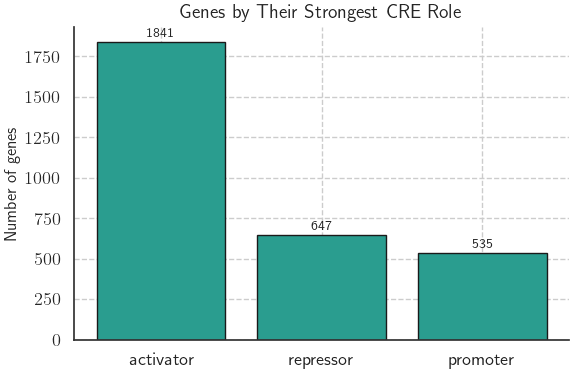

In [130]:
import matplotlib.pyplot as plt

# 1) counts & total
role_counts = strongest['role'].value_counts()
total_genes = len(strongest)

# 2) figure setup
fig, ax = plt.subplots(figsize=(6, 4))

# 3) bars in a professional teal, with black outline
bars = ax.bar(
    role_counts.index, 
    role_counts.values, 
    color='#2A9D8F',   # pretty, professional teal
    edgecolor='k', 
    linewidth=1
)

# 4) annotate counts above each bar
for bar in bars:
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        h + total_genes * 0.005,
        f"{h}",
        ha='center',
        va='bottom',
        fontsize=10
    )

# 5) clean up spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 6) labels & title
ax.set_ylabel("Number of genes", fontsize=12)
ax.set_title("Genes by Their Strongest CRE Role", fontsize=14)

plt.tight_layout()
plt.show()


1.ii. d Are intronic enhancers different from enhancers outside the transcript.

In [131]:
import os
import pandas as pd

# 2) Load your filtered peaks file
peaks_coords = pd.read_csv("ATAC_high_var.csv")

# 3) Print its column names
print("Columns in ATAC_high_var.csv:", peaks_coords.columns.tolist())



Columns in ATAC_high_var.csv: ['ImmGenATAC1219.peakID', 'chrom', 'Summit', 'mm10.60way.phastCons_scores', '_-log10_bestPvalue', 'Included.in.systematic.analysis', 'TSS', 'genes.within.100Kb', 'preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th', 'T.DN4.Th', 'T.ISP.Th', 'T.DP.Th', 'T.4.Th', 'T.8.Th', 'T.4.Nve.Sp', 'T.4.Nve.Fem.Sp', 'T.4.Sp.aCD3+CD40.18hr', 'T.8.Nve.Sp', 'Treg.4.25hi.Sp', 'Treg.4.FP3+.Nrplo.Co', 'T8.TN.P14.Sp', 'T8.TE.LCMV.d7.Sp', 'T8.MP.LCMV.d7.Sp', 'T8.IEL.LCMV.d7.SI', 'T8.Tcm.LCMV.d180.Sp', 'T8.Tem.LCMV.d180.Sp', 'NKT.Sp', 'NKT.Sp.LPS.3hr', 'NKT.Sp.LPS.18hr', 'NKT.Sp.LPS.3d', 'LTHSC.34-.BM', 'LTHSC.34+.BM', 'STHSC.150-.BM', 'MPP4.135+.BM', 'variance']


the high_conf table didn’t include the peak’s position, so i merged in the summit coordinate from our ATAC‐seq file

In [132]:
import pandas as pd

# 1) Load your filtered ATAC peaks
peaks_coords = pd.read_csv("ATAC_high_var.csv")

# 2) Select only the three columns we need and rename them
peaks_coords = (
    peaks_coords
    .loc[:, ['ImmGenATAC1219.peakID', 'chrom', 'Summit']]
    .rename(columns={
        'ImmGenATAC1219.peakID': 'peak_ID',
        'Summit': 'pos'   # single-base CRE coordinate
    })
)

# 3) Merge into high_conf by peak_ID
high_conf = high_conf.merge(
    peaks_coords,
    on='peak_ID',
    how='left'
)

# 4) Verify
print("Now high_conf has columns:", high_conf.columns.tolist())
print(high_conf[['peak_ID','chrom','pos']].head())


Now high_conf has columns: ['Unnamed: 0', 'gene', 'peak_ID', 'coefficient', 'r2', 'distance_to_tss', 'role', 'chrom', 'pos']
                   peak_ID chrom      pos
0  ImmGenATAC1219.peak_376  chr1  7088525
1  ImmGenATAC1219.peak_377  chr1  7088775
2  ImmGenATAC1219.peak_378  chr1  7089051
3  ImmGenATAC1219.peak_380  chr1  7096062
4  ImmGenATAC1219.peak_408  chr1  7147225


I first kept only those peaks whose role was activator or repressor (i.e. discarded promoters).

In [133]:
# 1) Define which roles count as “enhancer‐type”
enhancer_roles = ['activator', 'repressor']

# 2) Find all genes with ≥1 such CRE
genes_with_enh = (
    high_conf.loc[
        high_conf['role'].isin(enhancer_roles), 
        'gene'
    ]
    .unique()
)

print(f"{len(genes_with_enh)} genes have at least one activator or repressor")

# 3) Filter your high_conf to only those genes
high_conf = high_conf[high_conf['gene'].isin(genes_with_enh)].copy()

print("Now high_conf rows:", high_conf.shape[0])
print("Remaining roles:", high_conf['role'].value_counts())


2957 genes have at least one activator or repressor
Now high_conf rows: 28680
Remaining roles: role
repressor    13025
activator    12707
promoter      2948
Name: count, dtype: int64


loaded RefFlat and kept only the 2,957 genes present in our filtered high_conf

In [134]:
import pandas as pd

# 1) Path to your RefFlat file
refflat_path = "raw datasets/refFlat"  # add “.txt” if that’s the actual filename

# 2) Column names for RefFlat
rf_cols = [
    'geneName', 'transcriptName', 'chrom', 'strand',
    'txStart', 'txEnd', 'cdsStart', 'cdsEnd',
    'exonCount', 'exonStarts', 'exonEnds'
]

# 3) Load the whole RefFlat
rf = pd.read_csv(
    refflat_path,
    sep='\t',
    header=None,
    names=rf_cols
)

# 4) Filter to only genes present in your filtered high_conf
relevant_genes = high_conf['gene'].unique()
rf_filt = rf[ rf['geneName'].isin(relevant_genes) ].copy()

print(f"Loaded {len(rf)} transcripts total; {rf_filt['geneName'].nunique()} genes remain after filtering")
print("Example rows:", rf_filt.head(), sep="\n")


Loaded 47382 transcripts total; 2957 genes remain after filtering
Example rows:
    geneName transcriptName  chrom strand   txStart     txEnd  cdsStart  \
34  Itgb1bp1      NM_008403  chr12      -  21269801  21286284  21270885   
57     Atg4d      NM_153583   chr9      +  21265284  21274837  21265482   
69       St7   NM_001289626   chr6      +  17693993  17943023  17694211   
77     Nadk2   NM_001085410  chr15      +   9071259   9110496   9071501   
85      Plec   NM_001164203  chr15      -  76170973  76208253  76172169   

      cdsEnd  exonCount                                         exonStarts  \
34  21279471          7  21269801,21271418,21272055,21274765,21276819,2...   
57  21273436         10  21265284,21266738,21266906,21268250,21268604,2...   
69  17942765         15  17693993,17819249,17834616,17844908,17846198,1...   
77   9108357         14  9071259,9083269,9084161,9085724,9091174,909271...   
85  76192311         34  76170973,76178518,76182909,76183090,76183361,7...   



For each transcript, we turned its comma-separated exon starts/ends into Python lists, then created one intron interval between every pair of adjacent exons:

We merged these intron intervals onto our peaks by (gene,chrom), then checked whether the peak summit pos lies inside any intron:

In [135]:
import pandas as pd

# --- 1) Parse exonStarts/exonEnds into lists of ints (if you haven't yet)
rf_filt['exonStarts'] = (
    rf_filt['exonStarts']
      .str.rstrip(',').str.split(',')
      .apply(lambda L: list(map(int,L)))
)
rf_filt['exonEnds'] = (
    rf_filt['exonEnds']
      .str.rstrip(',').str.split(',')
      .apply(lambda L: list(map(int,L)))
)

# --- 2) Build a DataFrame of intron intervals
introns = []
for _, row in rf_filt.iterrows():
    starts, ends = row.exonStarts, row.exonEnds
    # for each adjacent exon pair, the intron is [end_i, start_{i+1})
    for i in range(len(starts)-1):
        introns.append({
            'gene': row.geneName,
            'chrom': row.chrom,
            'intron_start': ends[i],
            'intron_end':   starts[i+1]
        })
introns = pd.DataFrame(introns)

# --- 3) Merge introns onto your peaks by (gene, chrom)
# high_conf already has columns: gene, chrom, pos, peak_ID, role, coefficient
peaks = high_conf[['peak_ID','gene','chrom','pos']].copy()
m = peaks.merge(introns, on=['gene','chrom'], how='left')

# --- 4) Flag as intronic if pos ∈ [intron_start, intron_end)
m['is_intronic'] = (m['pos'] >= m['intron_start']) & (m['pos'] < m['intron_end'])

# --- 5) Collapse to one TRUE/FALSE per peak_ID
intronic_flag = (
    m.groupby('peak_ID')['is_intronic']
     .any()
     .rename('is_intronic')
     .reset_index()
)

# --- 6) Merge back into high_conf and label location
high_conf = high_conf.merge(intronic_flag, on='peak_ID', how='left')
high_conf['location'] = high_conf['is_intronic'].map({True:'intronic', False:'intergenic'})

# --- 7) Quick sanity check
print(high_conf[['peak_ID','gene','chrom','pos','location']].drop_duplicates().sample(5))


                          peak_ID    gene  chrom        pos    location
18793  ImmGenATAC1219.peak_357266  Kcnab2   chr4  152446674    intronic
22131  ImmGenATAC1219.peak_413873    Chd4   chr6  125192181  intergenic
8156   ImmGenATAC1219.peak_153252   Psme2  chr14   55591380  intergenic
24353  ImmGenATAC1219.peak_439449    Wee1   chr7  110121578  intergenic
17640  ImmGenATAC1219.peak_336616    Inip   chr4   59718761  intergenic


Finally, we counted how many CREs (and enhancer-type CREs) fell into each category:

In [136]:


# Counts for just enhancers (activators + repressors)
enh = high_conf[high_conf['role'].isin(['activator','repressor'])]
enh_counts = enh['location'].value_counts()
enh_pct    = enh_counts / enh_counts.sum() * 100
print("\nEnhancer‐type CREs:")
print(enh_counts)
print(enh_pct.map("{:.1f}%".format))



Enhancer‐type CREs:
location
intergenic    20470
intronic       5262
Name: count, dtype: int64
location
intergenic    79.6%
intronic      20.4%
Name: count, dtype: object


In [137]:
enh = high_conf.query("role in ['activator','repressor']")
enh['abs_coef'] = enh['coefficient'].abs()
intr = enh.loc[enh['location']=='intronic','abs_coef']
inter= enh.loc[enh['location']=='intergenic','abs_coef']


/var/folders/4h/4d6rt9vd0zl_794dt1wdryqr0000gn/T/ipykernel_7166/820424276.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enh['abs_coef'] = enh['coefficient'].abs()


In [139]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(intr, inter)
print("p-value =", p)


p-value = 1.942628690498378e-51


In [140]:
pd.crosstab(
    enh['location'],
    enh['role']
).apply(lambda row: row/row.sum(), axis=1)


role,activator,repressor
location,,
intergenic,0.470689,0.529311
intronic,0.583808,0.416192


In [146]:
# Subset to activator/repressor CREs and compute |β|
enh = high_conf[high_conf.role.isin(['activator','repressor'])].copy()
enh['abs_coef'] = enh['coefficient'].abs()

# Group by intronic vs. intergenic and compute mean & max
summary = enh.groupby('location')['abs_coef'] \
             .agg(mean_strength='mean', max_strength='max') \
             .reset_index()

print(summary)


     location  mean_strength  max_strength
0  intergenic       3.801026    341.968959
1    intronic       4.574022    329.004357


In [148]:
# Subset to activators & repressors and compute |β|
enh = high_conf[high_conf.role.isin(['activator','repressor'])].copy()
enh['abs_coef'] = enh['coefficient'].abs()

# Compute mean, median, max for each location
summary = enh.groupby('location')['abs_coef'].agg(
    mean='mean',
    median='median',
    maximum='max'
).reset_index()

print(summary.to_string(index=False))


  location     mean   median    maximum
intergenic 3.801026 0.861624 341.968959
  intronic 4.574022 1.373178 329.004357


seeing examples

In [151]:
# build the intron table again if you haven’t already
introns = []
for _,r in rf_filt.iterrows():
    starts, ends = r.exonStarts, r.exonEnds
    for i in range(len(starts)-1):
        introns.append({
            'gene':         r.geneName,
            'chrom':        r.chrom,
            'intron_start': ends[i],
            'intron_end':   starts[i+1]
        })
introns = pd.DataFrame(introns)

# Merge back to see exactly which intron each peak hit
m = enh[['peak_ID','gene','chrom','pos','location']].merge(
    introns, on=['gene','chrom'], how='left'
)
m['overlap_intron'] = (m.pos >= m.intron_start) & (m.pos < m.intron_end)

print("=== Random Intronic Examples ===")
print(
    m.query("location=='intronic' & overlap_intron")
     .sample(5, random_state=0)
     [['peak_ID','gene','chrom','pos','intron_start','intron_end']]
)

print("\n=== Random Intergenic Examples ===")
print(
    m.query("location=='intergenic'")
     .sample(5, random_state=0)
     [['peak_ID','gene','chrom','pos']]
)


=== Random Intronic Examples ===
                           peak_ID    gene  chrom        pos  intron_start  \
75550    ImmGenATAC1219.peak_79991   Zbtb4  chr11   69766523    69766085.0   
28965    ImmGenATAC1219.peak_40260   Stx11  chr10   12963476    12941983.0   
570562  ImmGenATAC1219.peak_498341   Fbxl2   chr9  113983468   113979670.0   
561811  ImmGenATAC1219.peak_483623    Bco2   chr9   50537432    50536368.0   
26961    ImmGenATAC1219.peak_38864  Ipcef1  chr10    7010757     6996576.0   

         intron_end  
75550    69775375.0  
28965    12963999.0  
570562  113983984.0  
561811   50538845.0  
26961     7023141.0  

=== Random Intergenic Examples ===
                           peak_ID    gene  chrom        pos
382020  ImmGenATAC1219.peak_356086  Pik3cd   chr4  149710735
534984  ImmGenATAC1219.peak_464158   Hook2   chr8   85081410
247136  ImmGenATAC1219.peak_231766   Prob1  chr18   35662211
82996    ImmGenATAC1219.peak_84542  Ggnbp2  chr11   84879854
462719  ImmGenATAC1219.pe

Many intronic peaks will be very close to the TSS (first intron), acting like proximal enhancers or alternative promoters, boosting their effect sizes.

Intergenic enhancers range from proximal to very distal; the bulk may lie further away and have more modest effects.

This suggests that, in our regression model, CREs located inside gene bodies tend to exert stronger regulatory effects on their linked target genes than those lying entirely outside the transcript.

Interpretation: The median |β| is ~0.86 for intergenic but ~1.37 for intronic enhancers—so intronic elements are stronger even when ignoring outliers. The IQR shows intronic sites also have a broader middle 50% (3.89 vs. 2.75).